# Wingsail Controller Prototype

In [11]:
# Install Python dependencies
!pip3 install numpy scipy matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [12]:
# Imports
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt


## Function `compute_reynolds_number` Implementation

It takes the apparent wind speed and the chord width to computes the Reynold's number. 

In [13]:
CHORD_WIDTH_MAIN_SAIL = 0.14  # meters, trim tab chord width is not included
KINEMATIC_VISCOSITY = 0.000014207  # {m^2 / s at 10degC} and air density at 1.225 {kg / m^3}


def compute_reynolds_number(apparent_wind_speed):
    reynolds_number = (apparent_wind_speed * CHORD_WIDTH_MAIN_SAIL) / KINEMATIC_VISCOSITY
    return reynolds_number


## Function `compute_angle_of_attack` Implementation

It takes the Reynolds number and uses a lookup table to find the angle of attack.

In [14]:
def compute_angle_of_attack(reynolds_number, look_up_table):
    desired_alpha = np.interp(reynolds_number, look_up_table[:, 0], look_up_table[:, 1])
    return desired_alpha


## Function `compute_trim_tab_angle` Implementation

It takes the desired alpha value and computes the resulting trim tab angle.

In [15]:
# wind_direction will use degrees unit and follow same convention of WindSensor.msg
# 0° means the apparent wind is blowing from the bow to the stern of the boat, increase CW
# Range: -180 < direction <= 180 for symmetry
def compute_trim_tab_angle(desired_alpha, wind_direction, boat_direction):
    # additional variables to be used in future more in depth calculations
    if wind_direction >= 0:
        trim_tab_angle = desired_alpha
    else:
        # wind_direction here helps dictate direction to rotate trim tab
        trim_tab_angle = -desired_alpha

    return trim_tab_angle


## Testing sample values:

In [16]:
apparent_wind_speed = 10  # m/s
wind_direction = 0  # degrees
boat_direction = 0  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

reynolds = compute_reynolds_number(apparent_wind_speed)
alpha = compute_angle_of_attack(reynolds, look_up_table)
trim_tab_angle = compute_trim_tab_angle(alpha, wind_direction, boat_direction)

print("Reynolds number: ", reynolds)
print("Angle of attack: ", alpha)
print("Trim tab angle: ", trim_tab_angle)


Reynolds number:  98542.97177447738
Angle of attack:  6.7208594354895475
Trim tab angle:  6.7208594354895475


## Test 2: Wind direction at 40 degrees

In [17]:
apparent_wind_speed = 100  # m/s
wind_direction = 40  # degrees
boat_direction = 0  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

reynolds = compute_reynolds_number(apparent_wind_speed)
alpha = compute_angle_of_attack(reynolds, look_up_table)
trim_tab_angle = compute_trim_tab_angle(alpha, wind_direction, boat_direction)

print("Reynolds number: ", reynolds)
print("Angle of attack: ", alpha)
print("Trim tab angle: ", trim_tab_angle)


Reynolds number:  985429.7177447738
Angle of attack:  9.992714858872388
Trim tab angle:  9.992714858872388


## Boat Diagram

### Function definitions

In [18]:
def rotatePointAroundPoint(point, center, angle):
    """
    Returns a point represented by 2 element array (e.g. [x, y]) rotated around a center point
    by angle in degrees. Rotation is done by translating point using center:
    translated_point = point - center

    then applies the rotation matrix:
    rotated_translated_point = rotation_matrix * translated_point

    then translating the rotated point by center
    rotated_point = rotated_translated_point + center

    Parameters:
        point (array): Point that will be rotated.
        center (array): point used as center of rotation for point.
        angle (float): angle in degrees to rotate point.

    Returns:
        rotated_point (array): Point that has been rotated.
    """

    point = np.array(point)
    center = np.array(center)

    angle = (angle / 360) * 2 * 3.14159 * -1

    rotation_matrix = np.array(
        [[np.cos(angle), -1 * np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )

    translated_point = point - center
    rotated_point = np.dot(rotation_matrix, translated_point)
    rotated_point = rotated_point + center

    return rotated_point


def rotate_object_around_origin(obj, angle):
    """
    Returns an object, represented by an array of points, with each point rotated around the
    origin by angle degrees.

    Parameters:
        obj (array): Array of points that represents an object.
        angle (float): angle in degrees to rotate object.

    Returns:
        obj (array): Array of points that represents an object, reach point rotated around the
        origin.
    """
    for i in range(len(obj)):
        obj[i] = rotatePointAroundPoint(obj[i], [0, 0], angle)
    return obj


def rotate_trimtab(sail, angle):
    """
    Returns an sail object, represented by an array of points, with the last point rotated around
    the second to last point by angle degrees.

    Parameters:
        sail (array): Array of points that represents a sail object.
        angle (float): angle in degrees to rotate last point of sail object.

    Returns:
        sail (array): Array of points that represents a sail object, with the last point rotated
        around the second to last point.
    """
    sail[-1] = rotatePointAroundPoint(sail[-1], sail[-2], angle)
    return sail


def drawWind(windDirection):
    """
    Draws a wind arrow on a plot using the given wind angle in degrees following WindSensor.msg
    convention.

    Parameters:
        windDirection (float): Wind direction given in angles

    Returns:
        void
    """
    windTail = [0, 3]
    windTail = rotatePointAroundPoint(windTail, [0, 0], windDirection)
    windHead = [0, -2]
    windHead = rotatePointAroundPoint(windHead, [0, 0], windDirection)
    plt.arrow(
        windTail[0],
        windTail[1],
        windHead[0],
        windHead[1],
        head_width=0.2,
        head_length=0.3,
        fc="black",
        ec="black",
        label="wind",
    )


def drawBoat():
    """
    Draws a boat on a plot with the bow of the boat pointing in the +y direction.

    Returns:
        void
    """
    boat = [[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]
    x_values = []
    y_values = []
    for i in range(len(boat)):
        x_values.append(boat[i][0])
        y_values.append(boat[i][1])

    plt.plot(x_values, y_values, color="red", alpha=0.5)


def drawSail(sail):
    """
    Draws a sail on the plot using the points contained in the sail object (array of points).

    Parameters:
        sail (array):Array of points that represents a sail object.

    Returns:
        void
    """
    x_values = []
    y_values = []
    for i in range(len(sail)):
        x_values.append(sail[i][0])
        y_values.append(sail[i][1])

    plt.plot(x_values[0:-3], y_values[0:-3], color="blue", label="mainsail")
    plt.plot(x_values[-4:-2], y_values[-4:-2], color="black", linestyle="dotted")
    plt.plot(x_values[-2:], y_values[-2:], color="green", label="trimtab")


def showPlot():
    """
    Prints out the plot.

    Returns:
        void
    """
    plt.xlim(-7, 7)
    plt.ylim(-5, 5)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xticks([])
    plt.yticks([])

    plt.title("Boat Diagram")

    plt.legend(loc="upper left")
    plt.show()


### Diagram Construction
The fun section! 
1. Input wind speed and wind direction in Input section 
2. then press "exceute cell and below" to draw plot

#### Input section

In [19]:
# input section
apparent_wind_speed = 0.5  # m/s
wind_direction = 50  # degrees, follows WindSensor.msg convention
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # [reynolds number, angle of attack(degrees)]


#### Drawing section

Wind direction:  20
Reynolds number:  4927.148588723869
Angle of attack:  5.75
Trim tab angle:  5.75


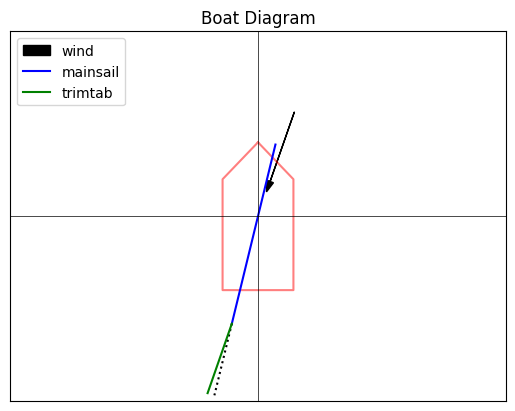

In [20]:
# Determine trimtab angle
reynolds = compute_reynolds_number(apparent_wind_speed)
a = compute_angle_of_attack(reynolds, look_up_table)
t = compute_trim_tab_angle(a, wind_direction, 0)

# print functions
print("Wind direction: ", wind_direction)
print("Reynolds number: ", reynolds)
print("Angle of attack: ", a)
print("Trim tab angle: ", t)

# construction and manipulation of wingsail
wingsail = [[0, 2], [0, 0], [0, -3], [0, -5], [0, -3], [0, -5]]
wingsail = rotate_object_around_origin(wingsail, wind_direction)
wingsail = rotate_trimtab(wingsail, t)
wingsail = rotate_object_around_origin(wingsail, -t)

# Drawing commands
drawWind(wind_direction)
drawBoat()
drawSail(wingsail)
showPlot()
